# Microsoft dataset
You can download the dataset into this folder from https://github.com/microsoft/clustered-nanopore-reads-dataset: 

### 1.) Visualize cluster size distribution

Mean cluster size (excluding empty): 27.01
Number of empty clusters: 16


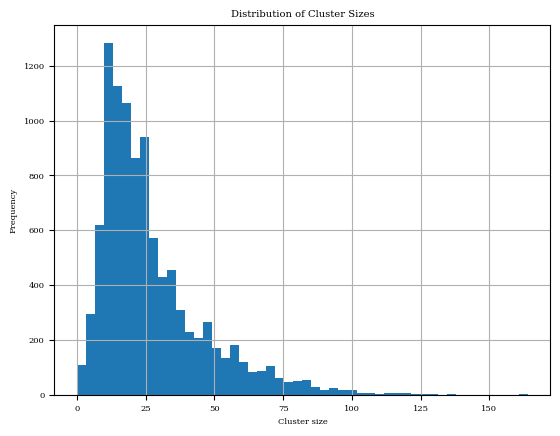

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

 # FOR PLOTTING need packages below or set latex to False
 # apt-get install cm-super
 # apt-get install texlive-fonts-recommended
 # apt-get install texlive-full 

# Settings 
FONTSIZE = 6
# With latex support
#plt.rcParams.update({
#    'text.usetex': True,
#    'font.family': 'serif',
#    'font.serif': ['Computer Modern Roman'],
#    'text.latex.preamble': r'\usepackage{amsmath} \usepackage{type1cm}',
#    'font.size': FONTSIZE,
#})

# Without latex support
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["DejaVu Serif", "Times New Roman", "Times"],
    "mathtext.fontset": "cm",  # Computer-Modern-ish math glyphs
    "font.size": FONTSIZE,
})

# Define file paths 
notebook_dir = os.getcwd()
centers_path = os.path.join(notebook_dir, "clustered-nanopore-reads-dataset", "Centers.txt")
clusters_path = os.path.join(notebook_dir, "clustered-nanopore-reads-dataset", "Clusters.txt")
separator = "==============================="

# Read Centers.txt
with open(centers_path, 'r') as f:
    ground_truth_list = [line.strip() for line in f]

# Read Clusters.txt
with open(clusters_path, 'r') as f:
    raw = f.read()

# Split clusters using separator
clusters_raw = raw.split(separator)

# Remove leading empty cluster if file starts with a separator
if len(clusters_raw) > 0 and clusters_raw[0].strip() == '':
    clusters_raw = clusters_raw[1:]

# Clean up reads in each cluster
clusters = [list(filter(None, cluster.strip().splitlines())) for cluster in clusters_raw]

# Check
assert len(clusters) == len(ground_truth_list), \
       f"Expected {len(ground_truth_list)} clusters, got {len(clusters)}"

# Compute cluster size distribution
cluster_sizes = [len(c) for c in clusters]

# Filter out empty clusters and compute mean size over non‐empty clusters
nonempty_sizes = [sz for sz in cluster_sizes if sz > 0]
if nonempty_sizes:
    mean_nonempty = np.mean(nonempty_sizes)
    print(f"Mean cluster size (excluding empty): {mean_nonempty:.2f}")
else:
    print("No non‐empty clusters to average over.")

# Count empty clusters
num_empty_clusters = sum(1 for size in cluster_sizes if size == 0)
print(f"Number of empty clusters: {num_empty_clusters}")

# Plot and show cluster size distribution
plt.hist(cluster_sizes, bins=50)
plt.xlabel("Cluster size")
plt.ylabel("Frequency")
plt.title("Distribution of Cluster Sizes")
plt.grid(True)
plt.show()


### 2.) Split in 80\% train and 10\% validation and test sets.

/tmp/ipykernel_74001/1077542116.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap    = cm.get_cmap('PuBu')
/tmp/ipykernel_74001/1077542116.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.85])


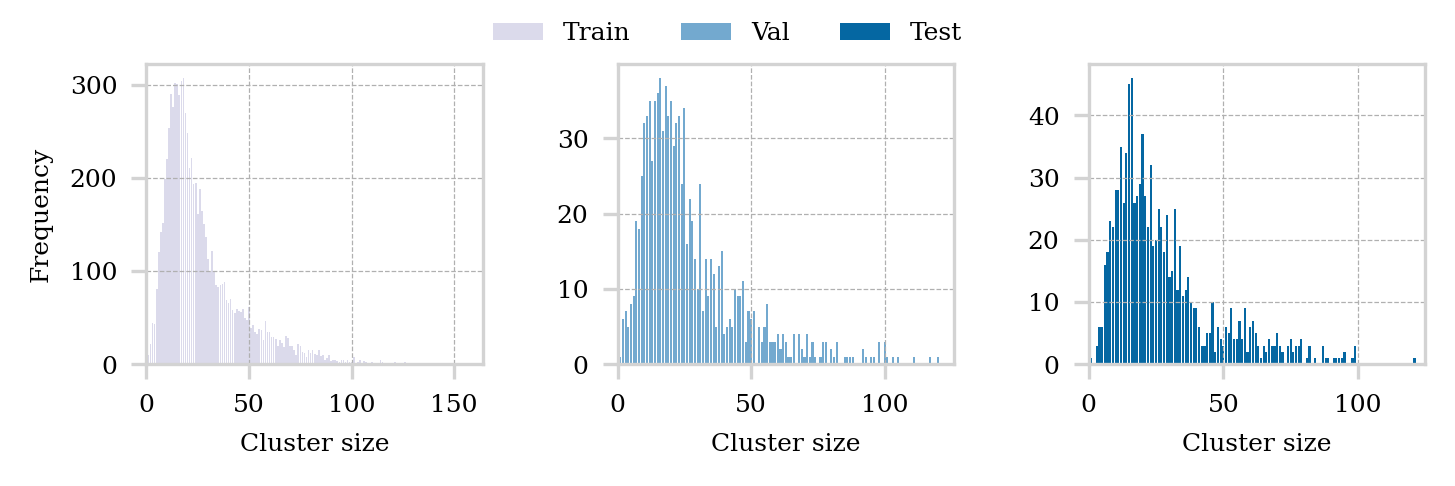

In [2]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from collections import defaultdict
import wandb
from matplotlib import cm
from matplotlib.patches import Patch


# Data split
indices = list(range(len(clusters)))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices,   test_indices = train_test_split(temp_indices,   test_size=0.5, random_state=42)

train_clusters = [clusters[i] for i in train_indices]
val_clusters   = [clusters[i] for i in val_indices]
test_clusters  = [clusters[i] for i in test_indices]

train_ground_truth = [ground_truth_list[i] for i in train_indices]
val_ground_truth   = [ground_truth_list[i] for i in val_indices]
test_ground_truth  = [ground_truth_list[i] for i in test_indices]


# Plot with individual bins for each cluster size
cmap    = cm.get_cmap('PuBu')
colors  = cmap(np.linspace(0.2, 0.8, 3))
labels  = ['Train', 'Val', 'Test']
splits  = [train_clusters, val_clusters, test_clusters]

fig, axs = plt.subplots(1, 3, figsize=(5.5, 1.3), dpi=300,
                        gridspec_kw={'wspace': 0.4})

# Calculate max sizes for each split
train_sizes = [len(c) for c in train_clusters]
val_sizes = [len(c) for c in val_clusters]
test_sizes = [len(c) for c in test_clusters]

max_sizes = [max(train_sizes), max(val_sizes), max(test_sizes)]

for ax, data, col, max_size in zip(axs, splits, colors, max_sizes):
    sizes = [len(c) for c in data]
    ax.hist(
        sizes,
        bins=range(0, max_size + 2),
        align='left',
        rwidth=0.8,
        color=col,
        edgecolor='none'          
    )
    ax.set_xlabel("Cluster size")
    # Each subplot gets independent axis limits
    ax.set_xlim(0, max_size)
    ax.grid(True, which='both', linestyle='--', linewidth=0.3)

axs[0].set_ylabel("Frequency")

for ax in axs:
    # light-gray frame
    for spine in ax.spines.values():
        spine.set_color('lightgray')
    # tick lines lightgray, tick labels black
    ax.tick_params(
        axis='both',
        which='both',
        color='lightgray',
        labelcolor='black', 
    )

handles = [Patch(facecolor=c, edgecolor='none') for c in colors]
fig.legend(handles, labels,
           loc='upper center',
           ncol=3,
           frameon=False,
           fontsize=FONTSIZE)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

In [3]:
# Count clusters with only one read in each split
num_train_singletons = sum(1 for c in train_clusters if len(c) == 1)
num_val_singletons = sum(1 for c in val_clusters if len(c) == 1)
num_test_singletons = sum(1 for c in test_clusters if len(c) == 1)

# Count clusters with more than one read
num_train_multi = sum(1 for c in train_clusters if len(c) > 1)
num_val_multi = sum(1 for c in val_clusters if len(c) > 1)
num_test_multi = sum(1 for c in test_clusters if len(c) > 1)

# Print the results
print(f"Train clusters with only 1 sequence: {num_train_singletons}")
print(f"Validation clusters with only 1 sequence: {num_val_singletons}")
print(f"Test clusters with only 1 sequence: {num_test_singletons}")

print(f"Train clusters with >1 sequence: {num_train_multi}")
print(f"Validation clusters with >1 sequence: {num_val_multi}")
print(f"Test clusters with >1 sequence: {num_test_multi}")


Train clusters with only 1 sequence: 10
Validation clusters with only 1 sequence: 1
Test clusters with only 1 sequence: 1
Train clusters with >1 sequence: 7976
Validation clusters with >1 sequence: 997
Test clusters with >1 sequence: 999


### 3.) Create subclusters of at most 10 reads to fit the model’s context length (for val and test sets)

Total training examples:   7976
Total validation examples: 4977
Total test examples:       5109

Subclusters with size <= 10:
Train: 1023/7976 (12.83%)
Val:   4977/4977 (100.00%)
Test:  5109/5109 (100.00%)


/tmp/ipykernel_74001/1904761402.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = cm.get_cmap('PuBu')
/tmp/ipykernel_74001/1904761402.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.85])


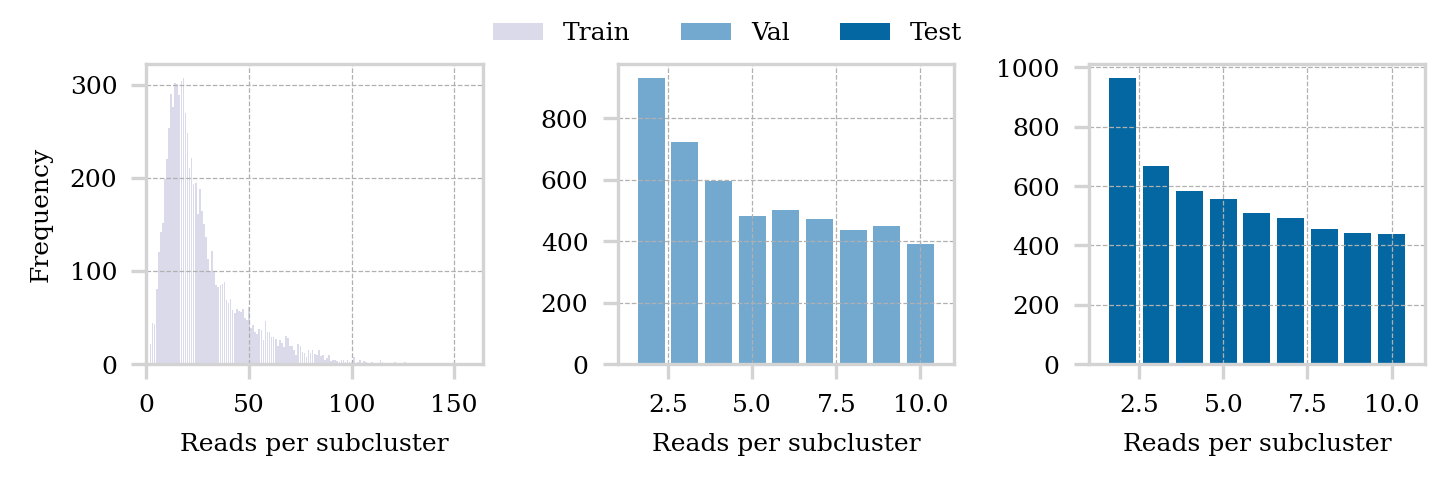

In [4]:
import os, sys, random
from pathlib import Path

notebook_dir = Path.cwd()
project_root = (notebook_dir / ".." / "..").resolve()
sys.path.insert(0, str(project_root))  # parent that contains 'src' directory

from src.utils.helper_functions import create_subclusters

# For reproducibility
random.seed(42)

# Create subclusters for test and val set. For train set we will sample cluster size dynamically during training. 
train_examples, train_cluster_sizes = create_subclusters(
    train_clusters, train_ground_truth, max_reads=None
)
val_examples, val_cluster_sizes = create_subclusters(
    val_clusters, val_ground_truth
)
test_examples, test_cluster_sizes = create_subclusters(
    test_clusters, test_ground_truth
)

print(f"Total training examples:   {len(train_examples)}")
print(f"Total validation examples: {len(val_examples)}")
print(f"Total test examples:       {len(test_examples)}")

max_train_size = max(train_cluster_sizes)
max_val_size   = max(val_cluster_sizes)
max_test_size  = max(test_cluster_sizes)

# Count subclusters with size <= 10 (max cluster size for model context)
train_lte_10 = sum(1 for size in train_cluster_sizes if size <= 10)
val_lte_10 = sum(1 for size in val_cluster_sizes if size <= 10)
test_lte_10 = sum(1 for size in test_cluster_sizes if size <= 10)

print(f"\nSubclusters with size <= 10:")
print(f"Train: {train_lte_10}/{len(train_cluster_sizes)} ({100*train_lte_10/len(train_cluster_sizes):.2f}%)")
print(f"Val:   {val_lte_10}/{len(val_cluster_sizes)} ({100*val_lte_10/len(val_cluster_sizes):.2f}%)")
print(f"Test:  {test_lte_10}/{len(test_cluster_sizes)} ({100*test_lte_10/len(test_cluster_sizes):.2f}%)")

# Plot with same visualization style as Section 2
cmap   = cm.get_cmap('PuBu')
colors = cmap(np.linspace(0.2, 0.8, 3))   
labels = ['Train', 'Val', 'Test']

fig, axs = plt.subplots(
    1, 3,
    figsize=(5.5, 1.3),
    dpi=300,
    gridspec_kw={'wspace': 0.4}
)

# Train should match Section 2 limits, Val/Test get their own limits
train_x_max = max([len(c) for c in train_clusters])  # Match Section 2

# Apply light‐gray spines & tick formatting to each axes
for ax in axs:
    for spine in ax.spines.values():
        spine.set_color('lightgray')
    ax.tick_params(
        axis='both',
        which='both',
        color='lightgray',
        labelcolor='black'
    )

# Plot 1: Train Subcluster Sizes (match Section 2 train limits)
axs[0].hist(
    train_cluster_sizes,
    bins=range(0, train_x_max + 2),
    align='left',
    rwidth=0.8,
    color=colors[0],
    edgecolor='none'
)
axs[0].set_xlabel("Reads per subcluster")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0, train_x_max)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.3)

# Plot 2: Val Subcluster Sizes (independent limits)
axs[1].hist(
    val_cluster_sizes,
    bins=range(0, max_val_size + 2),
    align='left',
    rwidth=0.8,
    color=colors[1],
    edgecolor='none'
)
axs[1].set_xlabel("Reads per subcluster")
axs[1].set_xlim(1, max_val_size+1)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.3)

# Plot 3: Test Subcluster Sizes (independent limits)
axs[2].hist(
    test_cluster_sizes,
    bins=range(0, max_test_size + 2),
    align='left',
    rwidth=0.8,
    color=colors[2],
    edgecolor='none'
)
axs[2].set_xlabel("Reads per subcluster")
axs[2].set_xlim(1, max_test_size+1)
axs[2].grid(True, which='both', linestyle='--', linewidth=0.3)

handles = [Patch(facecolor=c, edgecolor='none') for c in colors]
fig.legend(
    handles, 
    labels,
    loc='upper center',
    ncol=3,
    frameon=False,
    fontsize=FONTSIZE
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

In [5]:
# Print some example formatted training samples
print("\nSample training examples:")
for ex in train_examples[:5]:  
    print(ex)



Sample training examples:
TGGAATTCTCTTTCGCTACTTTACCATGTTGGAGCATAAGCTGGCTCAAGATGAAGCCTTCCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGAGTAAG|TGAATTCTTCGCTACTTTACCATGTTGGAGCATAAGGTTGATACTCAAGATGAAGCCTTCCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGAGTAA|TTCTGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAAGCTGGCTCAAGATGAAGCCTTCCACAAGGAGGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGGTAA|TGAATTCTTCTTCGCTACCTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTTCCCACAAGGACAGGCGGCTAGTGGTGTTATGGGATTGTCCTGTGAGTAA|TAGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTTCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATGTCCTGTGAGTAA|TGAATTCTTCTTCGCTACTTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAGGCTTCCACAAGGAGGCAGGCGACTGAAGTGGTGTTTATGGTTGTCCTGTGAAGTGA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTCCCACAAGCGAGGCAGGCGGCTAGTGGTGTTATGATTGTCCTGGTGAGTAA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTCAGCTGGCTCAAGATGGAAAAACCTTCCACAGAGGAGGCAGGCGGCTAGTGGTGTTATGGATGTCCTGTGGTAA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAAAGCTGGCTCAAGATGAAGCCTTCCACAAGAGGCAGGCGGCTAGTG

### 5.) Save Train, Val, and Test Data to Disk and Upload Test Data to Weights & Biases

In [6]:
import os
import sys
import json
import wandb
import torch
import pickle
import numpy as np
from datetime import datetime
from pathlib import Path

from src.data_pkg.prepare import encode_and_pad


# Config
sequence_type = "nuc"
block_size = 1500
output_dir = os.path.join("data_microsoft")
os.makedirs(output_dir, exist_ok=True) 

# Load vocab
data_pkg_dir = os.path.join(project_root, "src", "data_pkg")
meta_path = os.path.join(data_pkg_dir, f'meta_{sequence_type}.pkl')

if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    meta_vocab_size = meta['vocab_size']
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    raise FileNotFoundError(f"Meta file not found: {meta_path}")

# Save raw text
def write_data_to_file(filepath, data):
    with open(filepath, 'w') as f:
        for line in data:
            f.write(line.strip() + '\n')

write_data_to_file(os.path.join(output_dir, "train.txt"), train_examples)  # e.g., read1|read2:gt
write_data_to_file(os.path.join(output_dir, "val.txt"), val_examples)
write_data_to_file(os.path.join(output_dir, "test.txt"), test_examples)

# Regenerate reads.txt and ground_truth.txt from test_examples
reads_txt_path = os.path.join(output_dir, "reads.txt")
ground_truth_path = os.path.join(output_dir, "ground_truth.txt")

with open(reads_txt_path, 'w') as rf, open(ground_truth_path, 'w') as gf:
    for ex in test_examples:
        reads_part, gt = ex.split(":")
        reads = reads_part.split("|")
        for r in reads:
            rf.write(r.strip() + '\n')
        rf.write('===============================\n')
        gf.write(gt.strip() + '\n')

# Encode and pad only test data (val and train is done in finetuning script)
encode_and_pad(test_examples, "test", stoi, block_size, output_dir)

# Optional: Upload test set to W&B if < 2 GiB 
test_files = ["test.txt", "test_x.pt", "test_y.pt", "ground_truth.txt", "reads.txt"]
total_bytes = sum(os.path.getsize(os.path.join(output_dir, f)) for f in test_files)
max_bytes = 2 * 1024**3  # 2 GiB

upload_wandb=False # Set to True to enable W&B upload

if total_bytes < max_bytes and upload_wandb:
    wandb_project='TRACE_RECONSTRUCTION'
    wandb_entity=''   # Set your W&B entity here
    run = wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        name="microsoft_test_artifact",
        job_type="data_processing"
    )

    artifact_test = wandb.Artifact(
        name=f"Microsoft-test-{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        type="dataset",
        description="Microsoft DNA dataset test split with torch tensors",
        metadata={
            "sequence_type": sequence_type,
            "block_size": block_size,
            "vocab_size": meta_vocab_size,
        }
    )

    for f in test_files:
        artifact_test.add_file(os.path.join(output_dir, f))

    run.log_artifact(artifact_test)
    run.finish()
else:
    print(f"W&B set to {upload_wandb} or test data size {total_bytes / 1024**3:.2f} GiB exceeds 2 GiB, skipping W&B artifact.")


Saved 5109 examples to data_microsoft/test_x.pt and data_microsoft/test_y.pt
Tensor shapes: x=torch.Size([5109, 1499]), y=torch.Size([5109, 1499])
W&B set to False or test data size 0.12 GiB exceeds 2 GiB, skipping W&B artifact.


In [7]:
# Print stats and sample examples
print(f"\n# Train examples: {len(train_examples)}")
print("First 5 train examples:")
for ex in train_examples[:5]:
    print("  ", ex)

print(f"\n# Validation examples: {len(val_examples)}")
print("First 5 val examples:")
for ex in val_examples[:5]:
    print("  ", ex)

print(f"\n# Test examples: {len(test_examples)}")
print("First 5 test examples:")
for ex in test_examples[:5]:
    print("  ", ex)



# Train examples: 7976
First 5 train examples:
   TGGAATTCTCTTTCGCTACTTTACCATGTTGGAGCATAAGCTGGCTCAAGATGAAGCCTTCCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGAGTAAG|TGAATTCTTCGCTACTTTACCATGTTGGAGCATAAGGTTGATACTCAAGATGAAGCCTTCCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGAGTAA|TTCTGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAAGCTGGCTCAAGATGAAGCCTTCCACAAGGAGGGCAGGCGGCTAGTGGTGTTATGGATTGTCCTGTGGTAA|TGAATTCTTCTTCGCTACCTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTTCCCACAAGGACAGGCGGCTAGTGGTGTTATGGGATTGTCCTGTGAGTAA|TAGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTTCCACAAGGAGGCAGGCGGCTAGTGGTGTTATGGATGTCCTGTGAGTAA|TGAATTCTTCTTCGCTACTTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAGGCTTCCACAAGGAGGCAGGCGACTGAAGTGGTGTTTATGGTTGTCCTGTGAAGTGA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAGCTGGCTCAAGATGAAGCCTCCCACAAGCGAGGCAGGCGGCTAGTGGTGTTATGATTGTCCTGGTGAGTAA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTCAGCTGGCTCAAGATGGAAAAACCTTCCACAGAGGAGGCAGGCGGCTAGTGGTGTTATGGATGTCCTGTGGTAA|TGGAATTCTTCTTCGCTACTTTACCATGTTGGAGTATAAAAGCTGGCTCAAGATGAAGCCT

### Reclustering test data for self-reported DNAformer comparison

The Microsoft dataset does not provide explicit indices. Therefore, we first extract the shortest prefix length that uniquely identifies all ground truth sequences in the test set. These unique prefixes are then treated as indices for clustering, following the approach described in [Bar-Lev et al. (2025)](https://www.nature.com/articles/s42256-025-01003-z).


In [8]:
from typing import List

def find_min_unique_prefix_length(sequences: List[str]) -> int:
    """Find the shortest prefix length such that all sequences are uniquely identified."""
    max_len = max(len(seq) for seq in sequences) 
    for prefix_len in range(1, max_len + 1):
        prefixes = [seq[:prefix_len] for seq in sequences]
        if len(set(prefixes)) == len(sequences):
            return prefix_len
    return max_len  # Fallback: full length needed


min_prefix_length = find_min_unique_prefix_length(test_ground_truth)
print(f"Minimum prefix length is {min_prefix_length}")

Minimum prefix length is 9


In [9]:
from collections import defaultdict
from statistics import mean

# Flatten all reads from clusters
all_reads = []
for cluster in clusters:
    all_reads.extend(cluster)

# Extract unique prefixes from ground_truth
def extract_unique_prefixes(sequences: List[str], prefix_len: int) -> dict:
    """Returns a mapping from unique prefix to full sequence."""
    mapping = {}
    for seq in sequences:
        prefix = seq[:prefix_len]
        mapping[prefix] = seq
    return mapping

prefix_to_gt = extract_unique_prefixes(ground_truth_list, min_prefix_length)

# Bin reads by prefix
binned_reads = defaultdict(list)
for read in all_reads:
    prefix = read[:min_prefix_length]
    if prefix in prefix_to_gt:  # only keep reads that match a known prefix
        binned_reads[prefix].append(read)

# Filter out singleton bins
filtered_bins = {prefix: reads for prefix, reads in binned_reads.items() if len(reads) > 1}

# Create final reclustered set with ground truths
reclustered = []
for prefix, reads in filtered_bins.items():
    gt_seq = prefix_to_gt[prefix]
    reclustered.append({
        "index": prefix,
        "data": gt_seq,
        "noisy_copies": reads
    })

# Compute stats
num_clusters = len(reclustered)
avg_cluster_size = mean(len(entry["noisy_copies"]) for entry in reclustered)

# Assertions
#assert num_clusters == 9954, f"Expected 9954 clusters, got {num_clusters}"
#assert abs(avg_cluster_size - 17) < 0.5, f"Expected average cluster size ~17, got {avg_cluster_size:.2f}"

print(f"Reclustered set approximately matches stats reported by Bar-Lev et al. (2025): {num_clusters} clusters vs. 9954 (Bar-Lev et al.), average size {avg_cluster_size:.2f} vs. 17 (Bar-Lev et al.)")

Reclustered set approximately matches stats reported by Bar-Lev et al. (2025): 9729 clusters vs. 9954 (Bar-Lev et al.), average size 19.01 vs. 17 (Bar-Lev et al.)


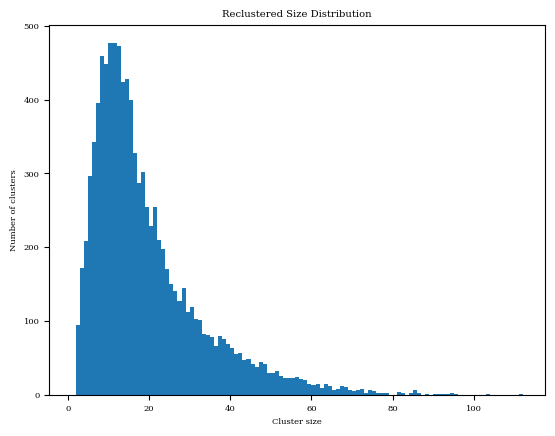

In [10]:

# Settings 
FONTSIZE = 11

cluster_sizes = [len(entry["noisy_copies"]) for entry in reclustered]

plt.hist(cluster_sizes, bins=range(1, max(cluster_sizes)+2))
plt.xlabel("Cluster size")
plt.ylabel("Number of clusters")
plt.title("Reclustered Size Distribution")
plt.show()


In [11]:
# Extract lists of reads and ground truths
reads_list = [entry["noisy_copies"] for entry in reclustered]
gt_list = [entry["data"] for entry in reclustered]

# Create examples in read1|read2|...|readN:ground_truth format and truncate to 10 reads to fit models context
reclustered_examples, reclustered_cluster_sizes = create_subclusters(
    reads_list, gt_list, truncate=True
)

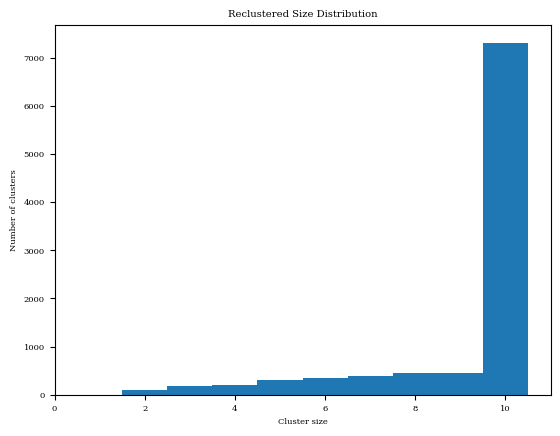

In [12]:
cluster_sizes = [
    len(example.split(":", 1)[0].split("|"))
    for example in reclustered_examples
]

plt.hist(
    cluster_sizes,
    bins=range(1, max(cluster_sizes) + 2),
    align='left'
)
plt.xlabel("Cluster size")
plt.ylabel("Number of clusters")
plt.title("Reclustered Size Distribution")
plt.show()


In [13]:
# Define output directory
reclustered_output_dir = os.path.join(notebook_dir, "reclustered_microsoft")
os.makedirs(reclustered_output_dir, exist_ok=True)

# Save to .txt
write_data_to_file(os.path.join(reclustered_output_dir, "test.txt"), reclustered_examples)

# Regenerate reads.txt and ground_truth.txt
with open(os.path.join(reclustered_output_dir, "reads.txt"), 'w') as rf, \
     open(os.path.join(reclustered_output_dir, "ground_truth.txt"), 'w') as gf:
    for ex in reclustered_examples:
        reads_part, gt = ex.split(":")
        reads = reads_part.split("|")
        for r in reads:
            rf.write(r.strip() + '\n')
        rf.write('===============================\n')
        gf.write(gt.strip() + '\n')

# Encode and pad
encode_and_pad(reclustered_examples, os.path.join(reclustered_output_dir, "test"), stoi, block_size, output_dir)  # will save test_x.pt and test_y.pt

# Upload to W&B
reclustered_test_files = ["test.txt", "test_x.pt", "test_y.pt", "ground_truth.txt", "reads.txt"]
total_bytes = sum(os.path.getsize(os.path.join(reclustered_output_dir, f)) for f in reclustered_test_files)


upload_wandb=False # Set to True to enable W&B upload

if total_bytes < max_bytes and upload_wandb:
    #wandb_project='set_yours'
    #wandb_entity='set_yours'
    run = wandb.init(
        project=wandb_project,
        entity=wandb_entity,
        name="microsoft_reclustered_test_artifact",
        job_type="data_processing"
    )

    artifact_test = wandb.Artifact(
        name=f"Microsoft-test-reclustered-{datetime.now().strftime('%Y%m%d_%H%M%S')}",
        type="dataset",
        description="Microsoft DNA dataset test split reclustered by unique prefix (DNAformer-style)",
        metadata={
            "sequence_type": sequence_type,
            "block_size": block_size,
            "vocab_size": meta_vocab_size,
            "reclustered": True,
            "min_prefix_length": min_prefix_length,
        }
    )

    for f in reclustered_test_files:
        artifact_test.add_file(os.path.join(reclustered_output_dir, f))

    run.log_artifact(artifact_test)
    run.finish()
else:
    print(f"W&B set to {upload_wandb} or reclustered test data size {total_bytes / 1024**3:.2f} GiB exceeds 2 GiB, skipping W&B artifact.")


Saved 9729 examples to /workspaces/TReconLM/data/microsoft_data/reclustered_microsoft/test_x.pt and /workspaces/TReconLM/data/microsoft_data/reclustered_microsoft/test_y.pt
Tensor shapes: x=torch.Size([9729, 1499]), y=torch.Size([9729, 1499])
W&B set to False or reclustered test data size 0.24 GiB exceeds 2 GiB, skipping W&B artifact.
